In [1]:
import json
import os
import sys
import argparse
import time
from datetime import datetime
import numpy as np
from tqdm import tqdm

import tensorflow as tf
### -----------------
### SD added
## Used to suppress TF warnings about 'weighted_metrics' and 'sample_weights'
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)
## USE the above to suppress all warning except ERROR. Do not use if debugging or prototyping
### -----------------

# import keras_tuner
tf.keras.backend.set_floatx('float64') 


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error as mae

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, ScalarFormatter, FormatStrFormatter

from matplotlib import animation
matplotlib.rc('animation', html='html5')
from IPython.display import display
import matplotlib.ticker as ticker
from matplotlib import rcParams
from matplotlib.offsetbox import AnchoredText
import matplotlib.gridspec as gridspec

# Plot parameters
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 20,
                     'lines.linewidth': 2,
                     'lines.markersize':10,
                     'axes.labelsize': 16, # fontsize for x and y labels (was 10)
                     'axes.titlesize': 20,
                     'xtick.labelsize': 16,
                     'ytick.labelsize': 16,
                     'legend.fontsize': 16,
                     'axes.linewidth': 2})

import itertools
colors = itertools.cycle(['r','g','b','m','y','c'])
markers = itertools.cycle(['p','d','o','^','s','x',]) #'D','H','v','*'])

from pathlib import Path, PurePath
from importlib import reload as reload

try:
    base_dir.exists()
except:
    curr_dir = Path().resolve()
    base_dir = curr_dir.parent  

scripts_dir = base_dir / "src"
work_dir = base_dir / "Burgers"
data_dir = base_dir / "Burgers" / "functions"

sys.path.append(str(scripts_dir.absolute()))
sys.path.append(str(work_dir.absolute()))
sys.path.append(str(data_dir.absolute()))


import autoencoder as ae
import burgers_exact as bg
import data_utils as du

%matplotlib inline

In [2]:
scaling=True
scaler_min=0
scaler_max=1

re_train_list=[15,25,35,50,70,100,200,400,800]
re_val_list=[10,1000]
re_test_list=[10,30,75,150,300,600,1000]

x_extent_train = 0.8
t_extent_train = 1.6
x_extent_val = 0.8
t_extent_val = 2
x_extent_test = 0.8
t_extent_test = 3.2

vxn = 300
vtn = 500

percent_branch=0.05
percent_trunk=0.05
percent_branch_test = 0.05
percent_trunk_test = 1
i=0

In [3]:

# ae.load_model(out_dir)
## Replace below with appropriate timestamp of saved model
benchmark_ae1_dir = '/Users/rditlpgr/Documents/ERDC/Projects/DON/Git/deeponet/Benchmark/Benchmark_Runs/AE_Benchmark/Burgers_AE_2024-04-01_173206_config_2'
benchmark_ae2_dir = '/Users/rditlpgr/Documents/ERDC/Projects/DON/Git/deeponet/Benchmark/Benchmark_Runs/AE_Benchmark/Burgers_AE_2024-04-01_173206_config_2'
benchmark_ae3_dir = '/Users/rditlpgr/Documents/ERDC/Projects/DON/Git/deeponet/Benchmark/Benchmark_Runs/AE_Benchmark/Burgers_AE_2024-04-01_173206_config_2'

loaded_ae_model1 = ae.load_model(benchmark_ae1_dir, comp=False)
loaded_ae_model2 = ae.load_model(benchmark_ae2_dir, comp=False)
loaded_ae_model3 = ae.load_model(benchmark_ae3_dir, comp=False)

benchmark_don1_dir = '/Users/rditlpgr/Documents/ERDC/Projects/DON/Git/deeponet/Benchmark/Benchmark_Runs/LDON_Benchmark/Burgers_LDON_2024-04-02_155504_config_1'
benchmark_don2_dir = '/Users/rditlpgr/Documents/ERDC/Projects/DON/Git/deeponet/Benchmark/Benchmark_Runs/LDON_Benchmark/Burgers_LDON_2024-04-02_211817_config_2'
benchmark_don3_dir = '/Users/rditlpgr/Documents/ERDC/Projects/DON/Git/deeponet/Benchmark/Benchmark_Runs/LDON_Benchmark/Burgers_LDON_2024-04-02_211817_config_3'

loaded_don_model1 = tf.keras.models.load_model(benchmark_don1_dir)
loaded_don_model2 = tf.keras.models.load_model(benchmark_don2_dir)
loaded_don_model3 = tf.keras.models.load_model(benchmark_don3_dir)

In [4]:
def define_grid(L, T, vxn, vtn):
    vx = np.linspace(0,L,vxn)
    vt = np.linspace(0,T,vtn)
    return vx, vt

def plot_bounds_1d(p1,p2,p3,L,T, label1=None, vmin1=None, vmax1=None, name=None):
    
    if vmin1 is None:
        vmin1 = np.amin([p1.min(), p2.min()])
        vmax1 = np.amax([p1.max(), p2.max()])

    fig, ((ax1), (ax2), (ax3)) = plt.subplots(1,3, figsize=(20,3))
    pcm1 = ax1.imshow(p1,cmap='jet',origin='lower',
                      vmin=vmin1, vmax=vmax1, extent=(0,T,0,L), aspect = 0.79)
    ax1.yaxis.set_ticks(np.arange(0,L+0.1,1))
    fig.colorbar(pcm1,ax=ax1)
    ax1.set_title('Truth' +'\n'+ '%s = %.2f'%('Re', label1)+'\n'+
                 '%.4f<u<%.4f'%(tf.reduce_min(p1).numpy(), tf.reduce_max(p1).numpy()))
    pcm2 = ax2.imshow(p2,cmap='jet',origin='lower',
                      vmin=vmin1, vmax=vmax1, extent=(0,T,0,L), aspect = 0.79)
    ax2.yaxis.set_ticks(np.arange(0,L+0.1,1))

    fig.colorbar(pcm2,ax=ax2)
    ax2.set_title('Prediction' +'\n'+ '%s = %.2f'%('Re', label1)+'\n'
                 '%.4f<u<%.4f'%(tf.reduce_min(p2).numpy(), tf.reduce_max(p2).numpy()))
    pcm3 = ax3.imshow(p3,cmap='coolwarm',origin='lower',
                      vmin=-0.05, vmax=0.05, extent=(0,T,0,L), aspect = 0.79)
    ax3.yaxis.set_ticks(np.arange(0,L+0.1,1))

    cbar = fig.colorbar(pcm3,ax=ax3)
    ax3.set_title('Error' +'\n'+ '%s = %.2f'%('Re', label1))
    
    ax1.set_ylabel('$x$',fontsize=18)
    ax1.set_xlabel('$t$',fontsize=18)
    ax2.set_xlabel('$t$',fontsize=18) 
    ax3.set_xlabel('$t$',fontsize=18)
    
    fig.tight_layout()
#     plt.savefig(name)

def plot_spcaetime_1d(p1,p2,p3,p4,p5,p6,T,L, colormap='jet', label1=None, label2=None, vmin1=None, vmax1=None, name=None):
    """
    Plot space-time 2d plots of 1D solutions
    Row1 : Predicted, True, Error for Soln1
    Row2 : Predicted, True, Error for Soln2
    """
    f = plt.figure(figsize=(15,10))
    gs = gridspec.GridSpec(3, 3, )
    gs.update(wspace=0.2, hspace=0.2) # set the spacing between axes.

    if vmin1 is None:
        vmin1 = np.amin([p1.min(), p2.min(), p3.min(), p4.min()])
        vmax1 = np.amax([p1.max(), p2.max(), p3.max(), p4.max()])

    ax1 = plt.subplot(gs[0, 0]);
    f1= ax1.imshow(p1,cmap=colormap,origin='lower',vmin=vmin1, vmax=vmax1, extent=(0,T,0,L), aspect = 0.59)
    ax1.yaxis.set_ticks(np.arange(0,L+0.1,1)); ax1.xaxis.set_ticks(np.arange(0,T+0.1,1))
    ax1.set_title('%s=%.2f'%('Re',label1[0]))

    ax2 = plt.subplot(gs[0, 1]);
    f2 = ax2.imshow(p2,cmap=colormap,origin='lower',vmin=vmin1, vmax=vmax1, extent=(0,T,0,L), aspect = 0.59)
    ax2.yaxis.set_ticks(np.arange(0,L+0.1,1)); ax2.xaxis.set_ticks(np.arange(0,T+0.1,1))
    ax2.set_title('%s=%.2f'%('Re',label1[1]))

    ax3 = plt.subplot(gs[1, 0]);
    f3= ax3.imshow(p3,cmap=colormap,origin='lower',vmin=vmin1, vmax=vmax1, extent=(0,T,0,L), aspect = 0.59)
    ax3.set_xticklabels([]); ax3.set_yticklabels([])
#     ax3.yaxis.set_ticks(np.arange(0,1.1,1))
    ax3.set_title('%s=%.2f'%('Re',label1[2]))

    ax4 = plt.subplot(gs[1, 1]);
    f4 = ax4.imshow(p4,cmap=colormap,origin='lower',vmin=vmin1, vmax=vmax1, extent=(0,T,0,L), aspect = 0.59)
    ax4.set_xticklabels([]); ax4.set_yticklabels([])
    ax4.set_title('%s=%.2f'%('Re',label1[3]))
    
    ax5 = plt.subplot(gs[2, 0]);
    f5= ax5.imshow(p5,cmap=colormap,origin='lower',vmin=vmin1, vmax=vmax1, extent=(0,T,0,L), aspect = 0.59)
    ax5.set_xticklabels([]); ax5.set_yticklabels([])
#     ax3.yaxis.set_ticks(np.arange(0,1.1,1))
    ax5.set_title('%s=%.2f'%('Re',label1[4]))

    ax6 = plt.subplot(gs[2, 1]);
    f6 = ax6.imshow(p6,cmap=colormap,origin='lower',vmin=vmin1, vmax=vmax1, extent=(0,T,0,L), aspect = 0.59)
    cbar1 = f.colorbar(f6, ax=list((ax1, ax2, ax3, ax4, ax5, ax6)),orientation='horizontal',aspect=50, pad=0.1)
    ax6.set_xticklabels([]); ax6.set_yticklabels([])
    ax6.set_title('%s=%.2f'%('Re',label1[5]))

    ax1.set_ylabel('$x$',fontsize=18); #ax2.set_ylabel('$x$',fontsize=18);
    ax3.set_ylabel('$x$',fontsize=18); #ax4.set_ylabel('$x$',fontsize=18);

    ax5.set_xlabel('$t$',fontsize=18); ax6.set_xlabel('$t$',fontsize=18); 
    ax5.set_ylabel('$x$',fontsize=18); #ax6.set_ylabel('$x$',fontsize=18);
#     plt.savefig(name)




# L-M-DeepONet

In [5]:
def multiple_ae_burgers(Re_list,vxn,VX,vtn,VT):
    
    number_cases = len(Re_list)
    
    burgers_array = np.zeros((number_cases*vtn,vxn))

    id0 = 0
    id1 = vtn
    for Re in Re_list:
        solution = bg.true_solution(VX,VT,Re)
        
        burgers_array[id0:id1,:] = solution
        id0 = id1; id1 = id1 + vtn  
            
    return burgers_array


def multiple_ldon_burgers(Re_list,vxn,VX,L,vtn,VT,T,latent_data):
    
    number_cases = len(Re_list)
    x_grid, t_grid = define_grid(L,T,vxn,vtn)

    for inx,Re in enumerate(Re_list):
        solution = bg.true_solution(VX,VT,Re)
        latent_target = latent_data[inx,:,:]

        
        u0 = solution[0,:]  ## initial solution to be used as input to branch
        
        for id_t,it in tqdm(enumerate(t_grid)):

            if inx==0 and id_t==0:
                b_input = u0
                t_input = it
                target = latent_target[id_t,:]
                
            else:
                b_input = np.vstack([b_input, u0])
                t_input = np.vstack([t_input, it])
                target = np.vstack([target,latent_target[id_t,:]])  
    
    return b_input, t_input, target

In [6]:
## Load training data for AE
Re_train = re_train_list
L_train = x_extent_train
T_train = t_extent_train
vx_train, vt_train = define_grid(L_train, T_train, vxn, vtn)
VX_train, VT_train = np.meshgrid(vx_train,vt_train)
train_data = multiple_ae_burgers(Re_train,vxn,VX_train,vtn,VT_train)

## Load validation data for AE
Re_val = re_val_list
L_val = x_extent_val
T_val = t_extent_val
vx_val, vt_val = define_grid(L_val, T_val, vxn, vtn)
VX_val, VT_val = np.meshgrid(vx_val,vt_val)
val_data = multiple_ae_burgers(Re_val,vxn,VX_val,vtn,VT_val)

## Load test data for AE
Re_test =  re_test_list
L_test = x_extent_test
T_test = t_extent_test
vx_test, vt_test = define_grid(L_test, T_test, vxn, vtn)
VX_test, VT_test = np.meshgrid(vx_test,vt_test)
test_data = multiple_ae_burgers(Re_test,vxn,VX_test,vtn,VT_test)

reload(du)
if scaling:
    scale_min, scale_max = 0, 1
    scaler = du.data_scaler(v_min=scale_min, v_max=scale_max)
    
    ## Flatten and scale
    train_data_scaled, = scaler((train_data,))
    val_data_scaled, test_data_scaled = scaler((val_data, test_data))

    data_min, data_max = scaler.u_min, scaler.u_max
    
    train_data_unscaled, val_data_unscaled, test_data_unscaled = scaler.scale_inverse((train_data_scaled, val_data_scaled, test_data_scaled))
else:
    train_data_scaled, val_data_scaled, test_data_scaled = train_data, val_data, test_data
    scale_min, scale_max = None, None


print(f"Training dataset statistics=====\n")
print(f"Max: {train_data.max()}, Min: {train_data.min()}" )
if scaling:
    print(f"Scaled Max: {train_data_scaled.max()}, Scaled Min: {train_data_scaled.min()}" )
    print(f"Reconstructed Max: {train_data_unscaled.max()}, Reconstructed Min: {train_data_unscaled.min()}" )

print(f"\n\nTest dataset statistics=====\n")
print(f"Max: {test_data.max()}, Min: {test_data.min()}" )
if scaling:
    print(f"Scaled Max: {test_data_scaled.max()}, Scaled Min: {test_data_scaled.min()}" )
    print(f"Reconstructed Max: {test_data_unscaled.max()}, Reconstructed Min: {test_data_unscaled.min()}" )


Nn = train_data_scaled.shape[1]
Nt = train_data_scaled.shape[0]

print(f"Full order dimension: {Nn}")

Training dataset statistics=====

Max: 0.4716823455361204, Min: 0.0
Scaled Max: 1.0, Scaled Min: 0.0
Reconstructed Max: 0.4716823455361204, Reconstructed Min: 0.0


Test dataset statistics=====

Max: 0.4763871154484893, Min: 0.0
Scaled Max: 1.0099744456346387, Scaled Min: 0.0
Reconstructed Max: 0.4763871154484893, Reconstructed Min: 0.0
Full order dimension: 300


110/110 [==============================] - 0s 375us/step


2024-04-05 22:57:08.254787: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
500it [00:00, 26284.05it/s]
500it [00:00, 6422.68it/s]
500it [00:00, 4082.40it/s]
500it [00:00, 2716.64it/s]
500it [00:00, 2104.69it/s]
500it [00:00, 1718.80it/s]
500it [00:00, 1460.85it/s]
500it [00:00, 1372.51it/s]
500it [00:00, 1113.15it/s]
500it [00:00, 26865.90it/s]
500it [00:00, 8260.80it/s]
500it [00:00, 35443.42it/s]
500it [00:00, 9430.19it/s]
500it [00:00, 3524.33it/s]
500it [00:00, 2473.00it/s]
500it [00:00, 2054.11it/s]
500it [00:00, 1716.69it/s]
500it [00:00, 1442.91it/s]


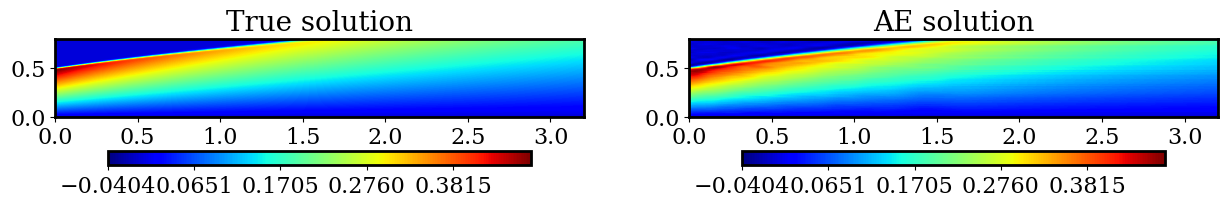

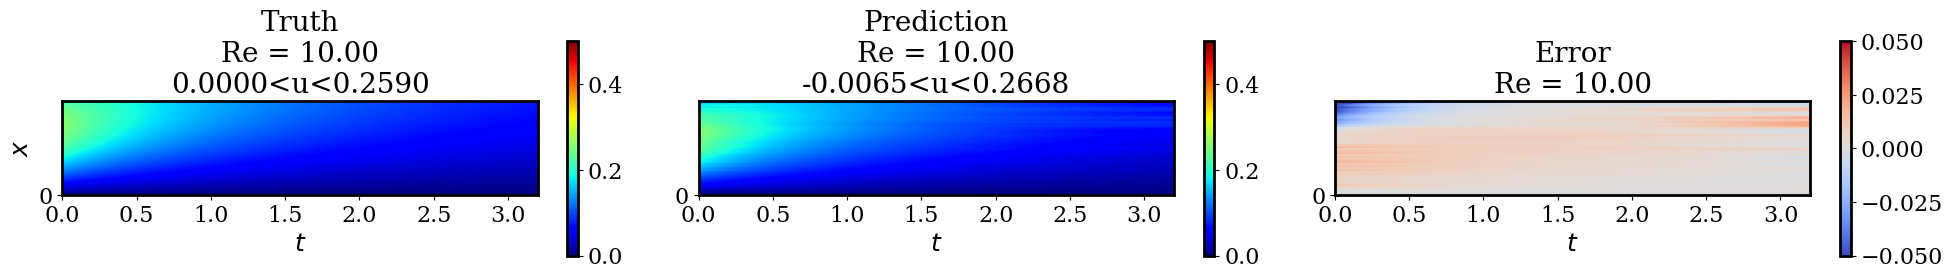

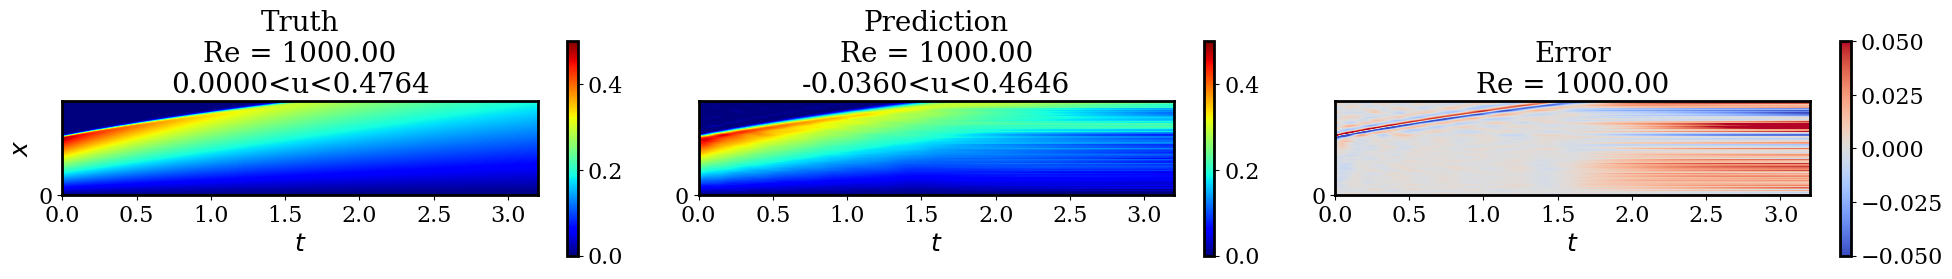

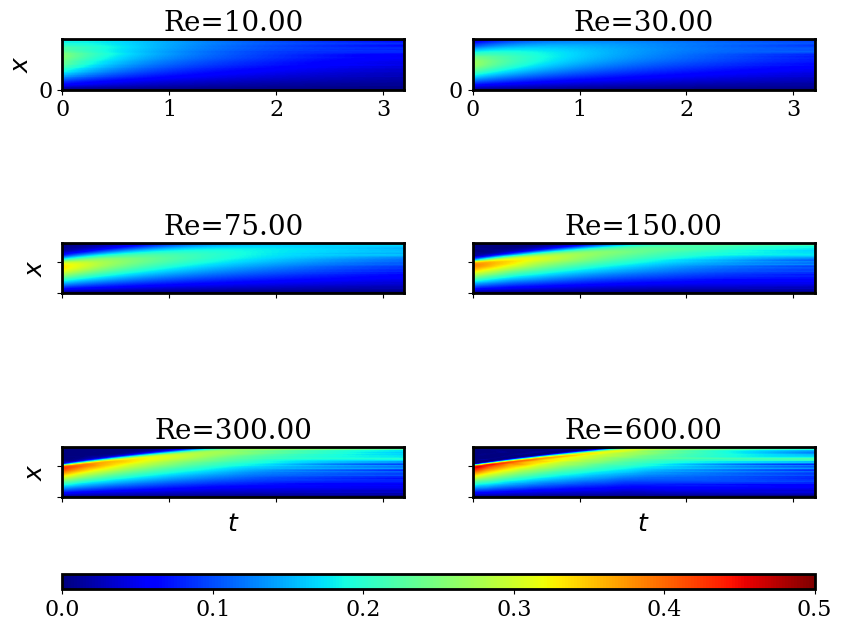

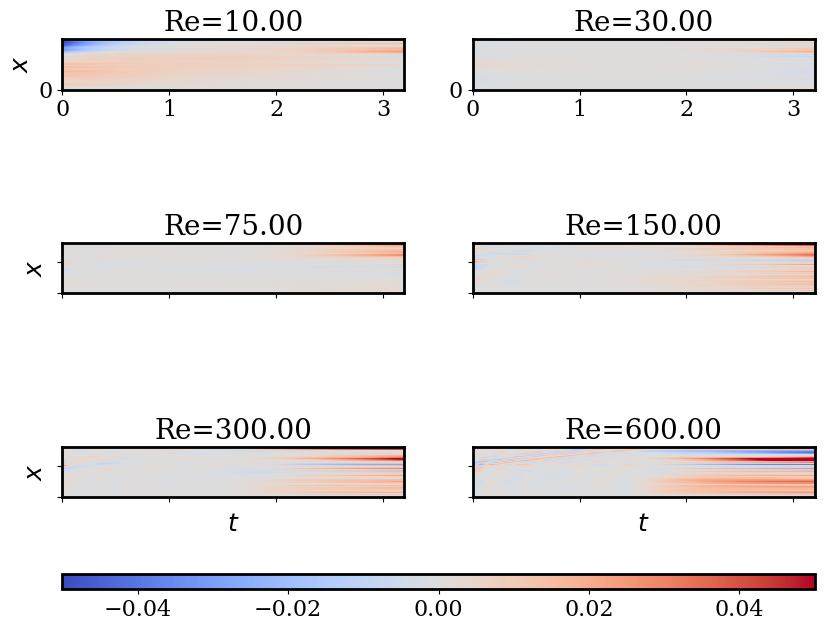

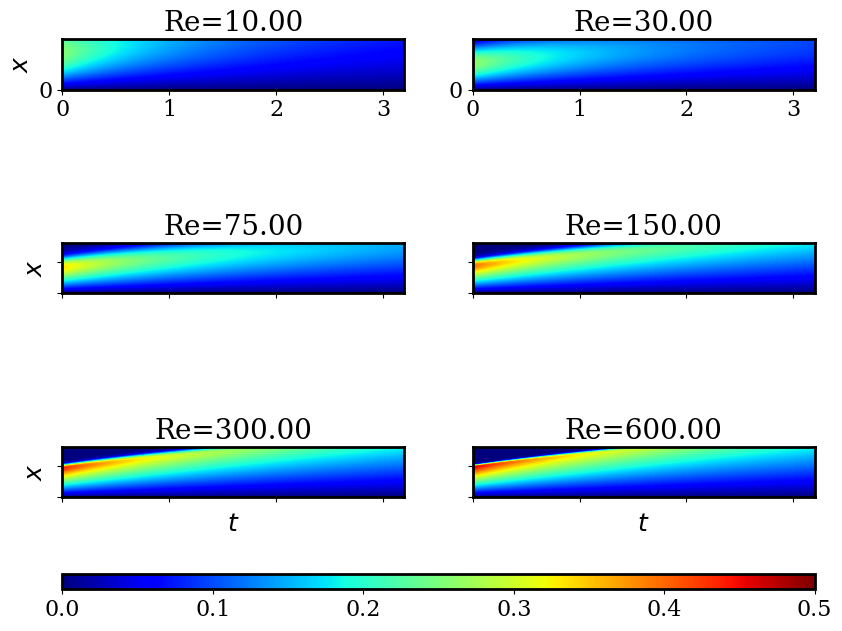

In [7]:
ae_model1,_ = loaded_ae_model1

## test AE predictions
pred_scaled = ae_model1.predict(test_data_scaled[:,:])
pred = scaler.scale_inverse((pred_scaled,))

true_field = np.reshape(np.array(test_data),(len(re_test_list),vtn,vxn))
true_field = np.moveaxis(true_field,1,2)

pred_field = np.reshape(np.array(pred),(len(re_test_list),vtn,vxn))
pred_field = np.moveaxis(pred_field,1,2)

valmax = np.amax([pred_field,true_field]) #true_field.max(); print(valmax)
valmin = np.amin([pred_field,true_field])  #true_field.min(); print(valmin)


lvls = np.linspace(np.amin([pred_field,true_field]),np.amax([pred_field,true_field]),50)
tks = lvls[0:-1:10]

fig, axs = plt.subplots(1,2, figsize=(15,5))
f1 = axs[0].imshow(true_field[-1],cmap='jet',origin='lower',vmin=valmin, vmax=valmax, extent=(0,T_test,0,L_test), aspect = 0.59)
plt.colorbar(f1, ticks = tks, orientation='horizontal',shrink=0.8,aspect=30, pad = 0.09)

f2 = axs[1].imshow(pred_field[-1],cmap='jet',origin='lower',vmin=valmin, vmax=valmax, extent=(0,T_test,0,L_test), aspect = 0.59)
plt.colorbar(f2, ticks = tks, orientation='horizontal',shrink=0.8,aspect=30, pad = 0.09)

axs[0].set_title(f"True solution")
axs[1].set_title(f"AE solution")

# fig.suptitle(f"{key} at t = {mesh['t'][int(itn%Nt)]/3600} hrs")

train_ls = ae_model1.encoder(train_data_scaled)
val_ls = ae_model1.encoder(val_data_scaled)
test_ls = ae_model1.encoder(test_data_scaled)

Nt_train = train_data_scaled.shape[0]
Nt_val = val_data_scaled.shape[0]
Nt_test = test_data_scaled.shape[0]

latent_dim = train_ls.shape[1]
# assert latent_dim == trial.params['latent_space'], "Optuna trials not available"

train_ls = np.reshape(train_ls,(len(re_train_list),vtn,latent_dim))
val_ls = np.reshape(val_ls,(len(re_val_list),vtn,latent_dim))
test_ls = np.reshape(test_ls,(len(re_test_list),vtn,latent_dim))

b_train, t_train, target_train = multiple_ldon_burgers(Re_train,vxn,VX_train,L_train,vtn,VT_train,T_train,train_ls)
b_val, t_val, target_val = multiple_ldon_burgers(Re_val,vxn,VX_val,L_val,vtn,VT_val,T_val,val_ls)


if scaling is True:
    t_scaler = MinMaxScaler(feature_range=( scaler_min,  scaler_max))
    b_scaler = MinMaxScaler(feature_range=( scaler_min,  scaler_max))
    ls_scaler = MinMaxScaler(feature_range=( scaler_min,  scaler_max))

    # changed global scaling, easier for now - PRC
    t_scaler.fit(np.concatenate([t_train,t_val]))
    b_scaler.fit(np.concatenate([b_train,b_val]))
    ls_scaler.fit(np.concatenate([target_train,target_val]))

    t_train = np.squeeze(t_scaler.transform(t_train))
    b_train = b_scaler.transform(b_train)
    target_train = np.squeeze(ls_scaler.transform(target_train))
    
    t_val = np.squeeze(t_scaler.transform(t_val))
    b_val = b_scaler.transform(b_val)
    target_val = np.squeeze(ls_scaler.transform(target_val))
    

## Evaluate the trained LDON model on test data
b_test, t_test, target_test = multiple_ldon_burgers(Re_test,vxn,VX_test,L_test,vtn,VT_test,T_test,test_ls)

if scaling is True:

    t_test = np.squeeze(t_scaler.transform(t_test))
    b_test = b_scaler.transform(b_test)
    target_test = np.squeeze(ls_scaler.transform(target_test))
    
    
model1 = loaded_don_model1

res = model1([b_test, t_test])

if  scaling is True:
    res = ls_scaler.inverse_transform(res)
    
full_res = ae_model1.decoder(res).numpy()
full_res = np.squeeze(scaler.scale_inverse((full_res,)))


test = np.reshape(np.array(full_res),(len(re_test_list),vtn,vxn))
target = np.reshape(np.array(test_data_unscaled),(len(re_test_list),vtn,vxn))

    
# full_res = ae_model1.decoder(res).numpy()
# full_res = np.squeeze(scaler.scale_inverse((full_res,)))


# test = np.reshape(np.array(full_res),(len(re_test_list),vtn,vxn))
# target_test = np.reshape(np.array(test_data_unscaled),(len(re_test_list),vtn,vxn))


error = test - target
rmse111 = np.sqrt(np.mean((test - target)**2))


plot_bounds_1d(target[0].T,test[0].T,error[0].T, L_test, T_test, label1= re_test_list[0], vmin1=0, vmax1=0.5,name='low_re'+str(i))
plot_bounds_1d(target[-1].T,test[-1].T,error[-1].T, L_test, T_test, label1= re_test_list[-1], vmin1=0, vmax1=0.5, name='high_re'+str(i))

# test[:,:,id_t]=1000
# test[:,id_x,:]=1000
# burgers_array_test[:,:,id_t]=1000
# burgers_array_test[:,id_x,:]=1000
# error[:,:,id_t]=1000
# error[:,id_x,:]=1000

plot_spcaetime_1d(test[0].T,test[1].T,
                  test[2].T,test[3].T,
                  test[4].T,test[5].T,
                  T_test,L_test,label1= re_test_list,
                  vmin1=0,
                  vmax1=0.5,                      
                  name='prediction'+str(i))

plot_spcaetime_1d(error[0].T,error[1].T,
                  error[2].T,error[3].T,
                  error[4].T,error[5].T,
                  T_test,L_test,
                  colormap='coolwarm',label1= re_test_list,
                  vmin1=-0.05,
                  vmax1=0.05,
                  name='error'+str(i))

plot_spcaetime_1d(target[0].T,target[1].T,
                  target[2].T,target[3].T,
                  target[4].T,target[5].T,
                  T_test,L_test,label1= re_test_list,
                  vmin1=0,
                  vmax1=0.5,    
                  name='truth')

110/110 [==============================] - 0s 438us/step


500it [00:00, 36629.56it/s]
500it [00:00, 6252.19it/s]
500it [00:00, 5665.15it/s]
500it [00:00, 2637.31it/s]
500it [00:00, 2052.70it/s]
500it [00:00, 1720.27it/s]
500it [00:00, 1666.63it/s]
500it [00:00, 1328.19it/s]
500it [00:00, 1234.36it/s]
500it [00:00, 24726.78it/s]
500it [00:00, 11948.02it/s]
500it [00:00, 38816.74it/s]
500it [00:00, 11977.50it/s]
500it [00:00, 3639.92it/s]
500it [00:00, 3190.26it/s]
500it [00:00, 2005.80it/s]
500it [00:00, 1726.09it/s]
500it [00:00, 1652.12it/s]


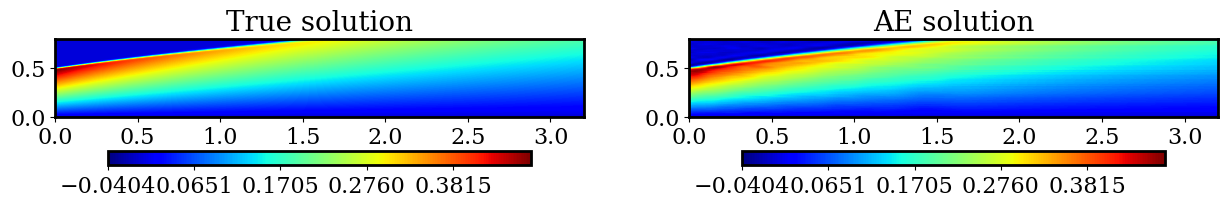

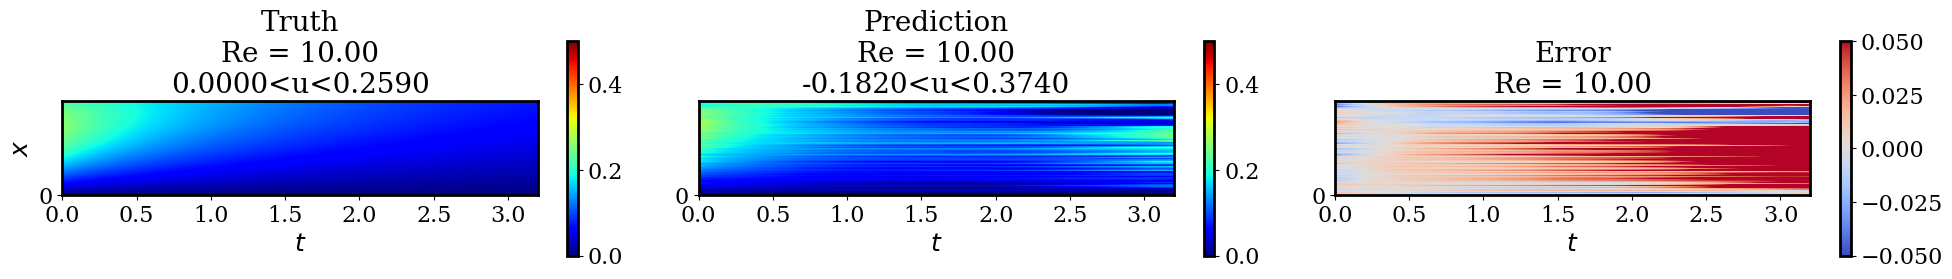

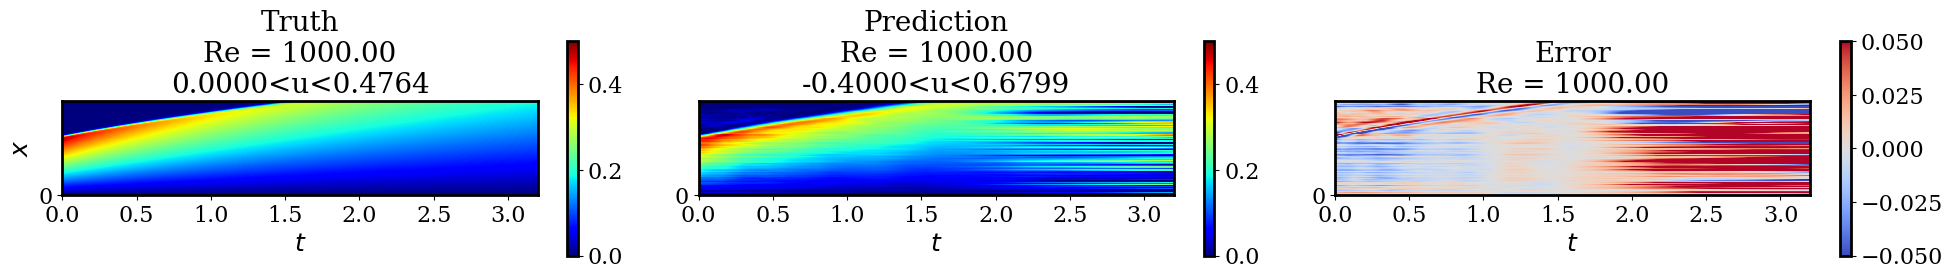

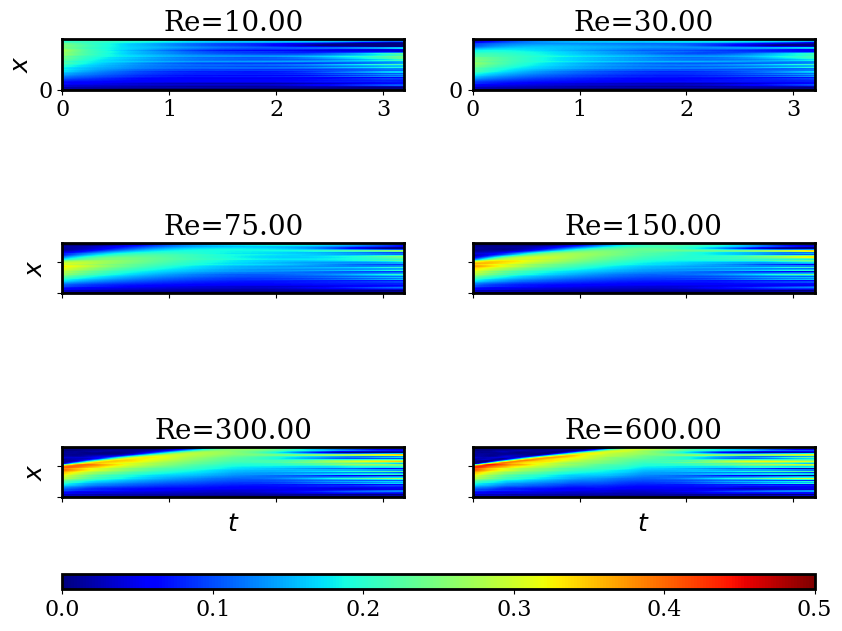

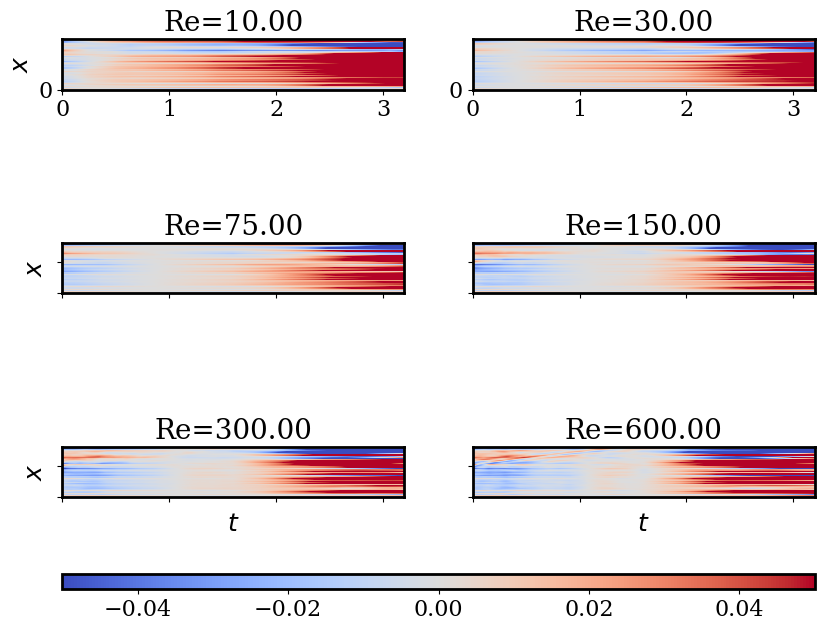

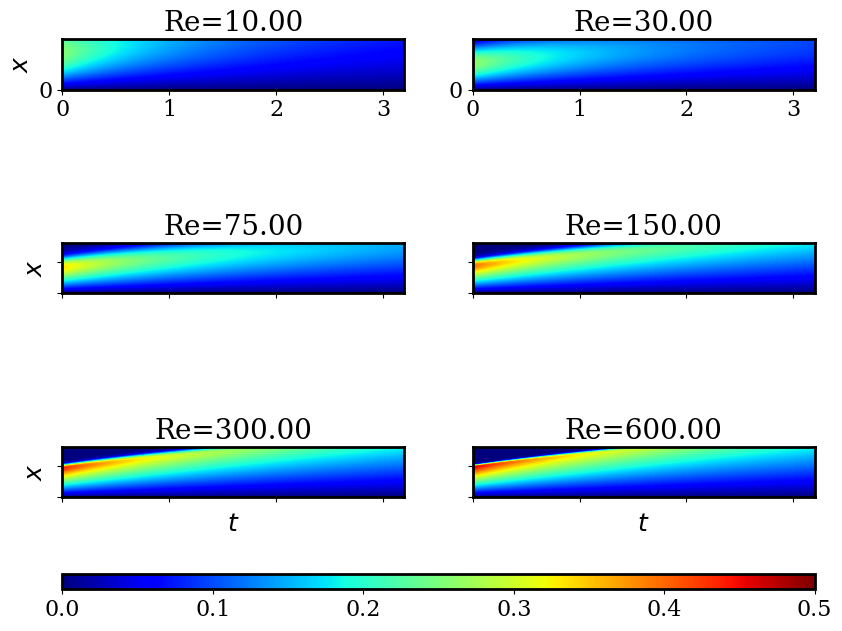

In [8]:
ae_model2,_ = loaded_ae_model2

## test AE predictions
pred_scaled = ae_model2.predict(test_data_scaled[:,:])
pred = scaler.scale_inverse((pred_scaled,))

true_field = np.reshape(np.array(test_data),(len(re_test_list),vtn,vxn))
true_field = np.moveaxis(true_field,1,2)

pred_field = np.reshape(np.array(pred),(len(re_test_list),vtn,vxn))
pred_field = np.moveaxis(pred_field,1,2)

valmax = np.amax([pred_field,true_field]) #true_field.max(); print(valmax)
valmin = np.amin([pred_field,true_field])  #true_field.min(); print(valmin)


lvls = np.linspace(np.amin([pred_field,true_field]),np.amax([pred_field,true_field]),50)
tks = lvls[0:-1:10]

fig, axs = plt.subplots(1,2, figsize=(15,5))
f1 = axs[0].imshow(true_field[-1],cmap='jet',origin='lower',vmin=valmin, vmax=valmax, extent=(0,T_test,0,L_test), aspect = 0.59)
plt.colorbar(f1, ticks = tks, orientation='horizontal',shrink=0.8,aspect=30, pad = 0.09)

f2 = axs[1].imshow(pred_field[-1],cmap='jet',origin='lower',vmin=valmin, vmax=valmax, extent=(0,T_test,0,L_test), aspect = 0.59)
plt.colorbar(f2, ticks = tks, orientation='horizontal',shrink=0.8,aspect=30, pad = 0.09)

axs[0].set_title(f"True solution")
axs[1].set_title(f"AE solution")

# fig.suptitle(f"{key} at t = {mesh['t'][int(itn%Nt)]/3600} hrs")

train_ls = ae_model2.encoder(train_data_scaled)
val_ls = ae_model2.encoder(val_data_scaled)
test_ls = ae_model2.encoder(test_data_scaled)

Nt_train = train_data_scaled.shape[0]
Nt_val = val_data_scaled.shape[0]
Nt_test = test_data_scaled.shape[0]

latent_dim = train_ls.shape[1]
# assert latent_dim == trial.params['latent_space'], "Optuna trials not available"

train_ls = np.reshape(train_ls,(len(re_train_list),vtn,latent_dim))
val_ls = np.reshape(val_ls,(len(re_val_list),int(Nt_val/len(re_val_list)),latent_dim))
test_ls = np.reshape(test_ls,(len(re_test_list),int(Nt_test/len(re_test_list)),latent_dim))

b_train, t_train, target_train = multiple_ldon_burgers(Re_train,vxn,VX_train,L_train,vtn,VT_train,T_train,train_ls)
b_val, t_val, target_val = multiple_ldon_burgers(Re_val,vxn,VX_val,L_val,vtn,VT_val,T_val,val_ls)


if scaling is True:
    t_scaler = MinMaxScaler(feature_range=( scaler_min,  scaler_max))
    b_scaler = MinMaxScaler(feature_range=( scaler_min,  scaler_max))
    ls_scaler = MinMaxScaler(feature_range=( scaler_min,  scaler_max))

    # changed global scaling, easier for now - PRC
    t_scaler.fit(np.concatenate([t_train,t_val]))
    b_scaler.fit(np.concatenate([b_train,b_val]))
    ls_scaler.fit(np.concatenate([target_train,target_val]))

    t_train = np.squeeze(t_scaler.transform(t_train))
    b_train = b_scaler.transform(b_train)
    target_train = np.squeeze(ls_scaler.transform(target_train))
    
    t_val = np.squeeze(t_scaler.transform(t_val))
    b_val = b_scaler.transform(b_val)
    target_val = np.squeeze(ls_scaler.transform(target_val))
    

## Evaluate the trained LDON model on test data
b_test, t_test, target_test = multiple_ldon_burgers(Re_test,vxn,VX_test,L_test,vtn,VT_test,T_test,test_ls)

if scaling is True:

    t_test = np.squeeze(t_scaler.transform(t_test))
    b_test = b_scaler.transform(b_test)
    target_test = np.squeeze(ls_scaler.transform(target_test))
    
    
model2 = loaded_don_model2

res = model2([b_test, t_test])

if  scaling is True:
    res = ls_scaler.inverse_transform(res)
    
full_res = ae_model2.decoder(res).numpy()
full_res = np.squeeze(scaler.scale_inverse((full_res,)))


test = np.reshape(np.array(full_res),(len(re_test_list),vtn,vxn))
target = np.reshape(np.array(test_data_unscaled),(len(re_test_list),vtn,vxn))

    
# full_res = ae_model2.decoder(res).numpy()
# full_res = np.squeeze(scaler.scale_inverse((full_res,)))


# test = np.reshape(np.array(full_res),(len(re_test_list),vtn,vxn))
# target_test = np.reshape(np.array(test_data_unscaled),(len(re_test_list),vtn,vxn))


error = test - target
rmse222 = np.sqrt(np.mean((test - target)**2))


plot_bounds_1d(target[0].T,test[0].T,error[0].T, L_test, T_test, label1= re_test_list[0], vmin1=0, vmax1=0.5,name='low_re'+str(i))
plot_bounds_1d(target[-1].T,test[-1].T,error[-1].T, L_test, T_test, label1= re_test_list[-1], vmin1=0, vmax1=0.5, name='high_re'+str(i))

# test[:,:,id_t]=1000
# test[:,id_x,:]=1000
# burgers_array_test[:,:,id_t]=1000
# burgers_array_test[:,id_x,:]=1000
# error[:,:,id_t]=1000
# error[:,id_x,:]=1000

plot_spcaetime_1d(test[0].T,test[1].T,
                  test[2].T,test[3].T,
                  test[4].T,test[5].T,
                  T_test,L_test,label1= re_test_list,
                  vmin1=0,
                  vmax1=0.5,                      
                  name='prediction'+str(i))

plot_spcaetime_1d(error[0].T,error[1].T,
                  error[2].T,error[3].T,
                  error[4].T,error[5].T,
                  T_test,L_test,
                  colormap='coolwarm',label1= re_test_list,
                  vmin1=-0.05,
                  vmax1=0.05,
                  name='error'+str(i))

plot_spcaetime_1d(target[0].T,target[1].T,
                  target[2].T,target[3].T,
                  target[4].T,target[5].T,
                  T_test,L_test,label1= re_test_list,
                  vmin1=0,
                  vmax1=0.5,    
                  name='truth')

110/110 [==============================] - 0s 403us/step


500it [00:00, 41785.09it/s]
500it [00:00, 11199.21it/s]
500it [00:00, 4213.15it/s]
500it [00:00, 3066.66it/s]
500it [00:00, 2080.98it/s]
500it [00:00, 1686.33it/s]
500it [00:00, 1471.32it/s]
500it [00:00, 1315.80it/s]
500it [00:00, 1265.26it/s]
500it [00:00, 40627.52it/s]
500it [00:00, 10349.36it/s]
500it [00:00, 47210.82it/s]
500it [00:00, 7463.44it/s]
500it [00:00, 5825.55it/s]
500it [00:00, 3062.77it/s]
500it [00:00, 2042.58it/s]
500it [00:00, 1699.03it/s]
500it [00:00, 1460.63it/s]


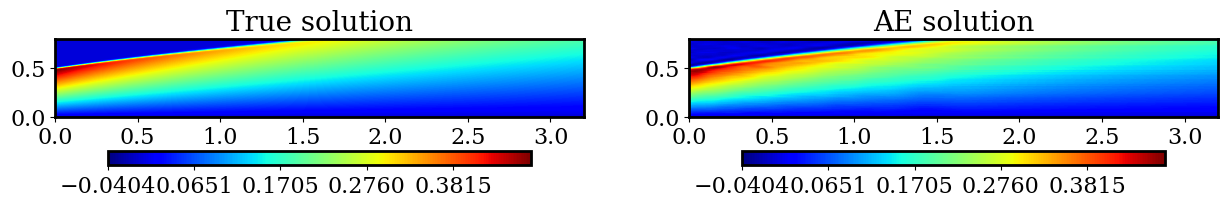

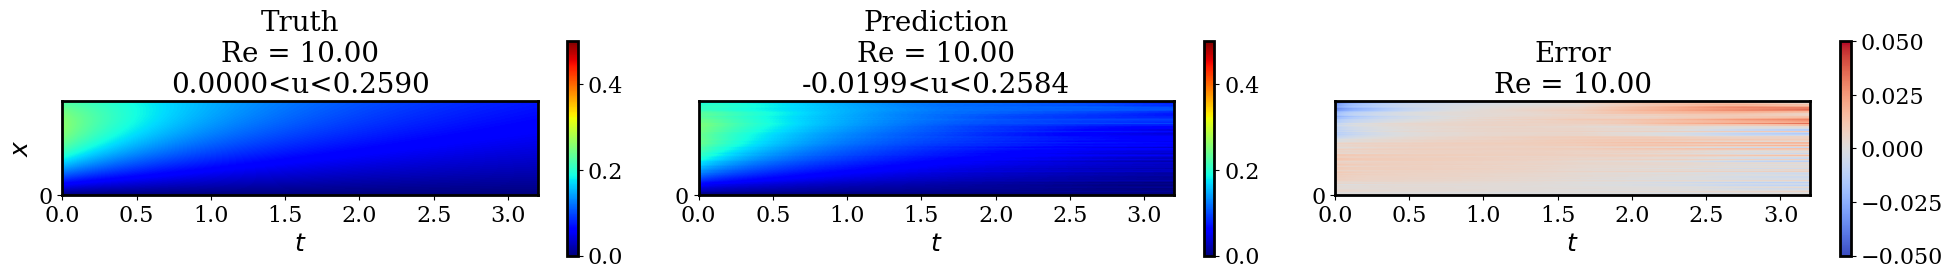

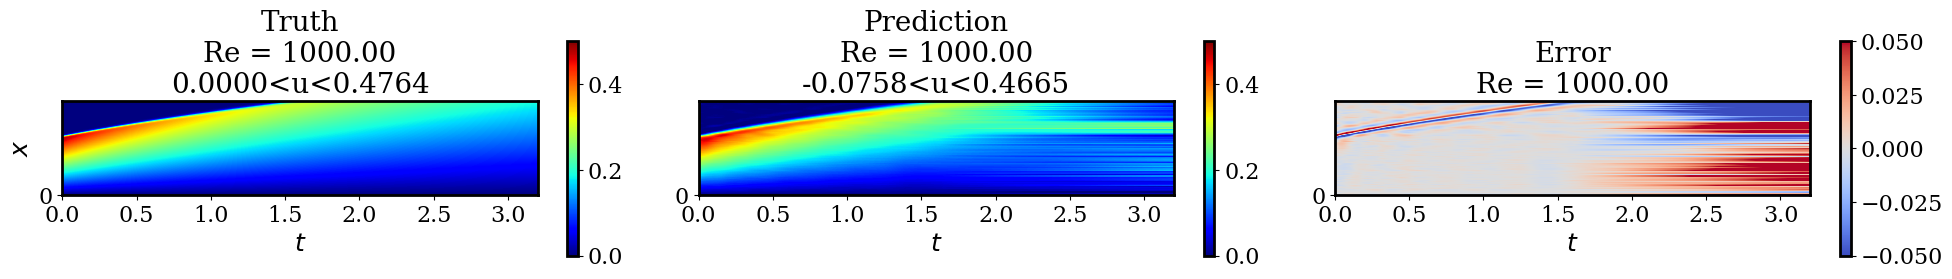

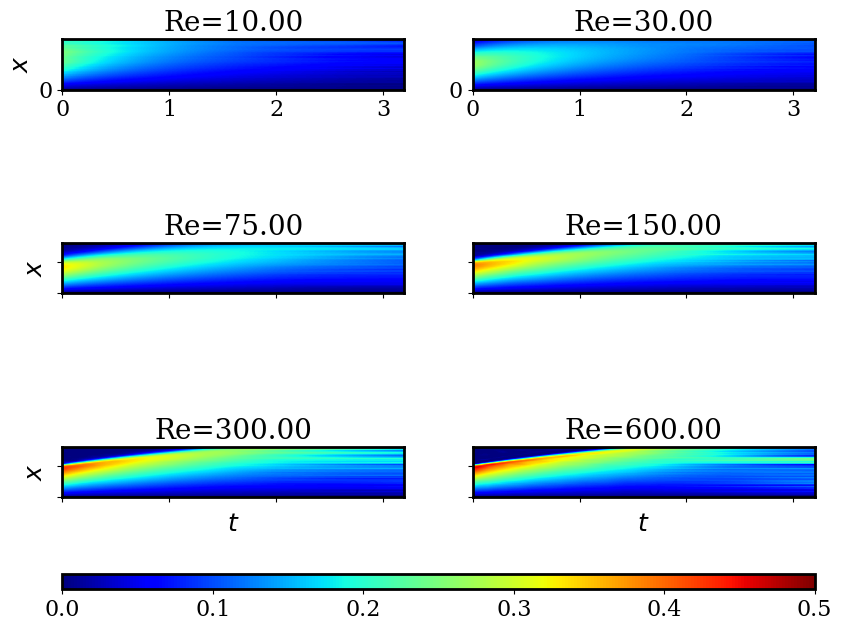

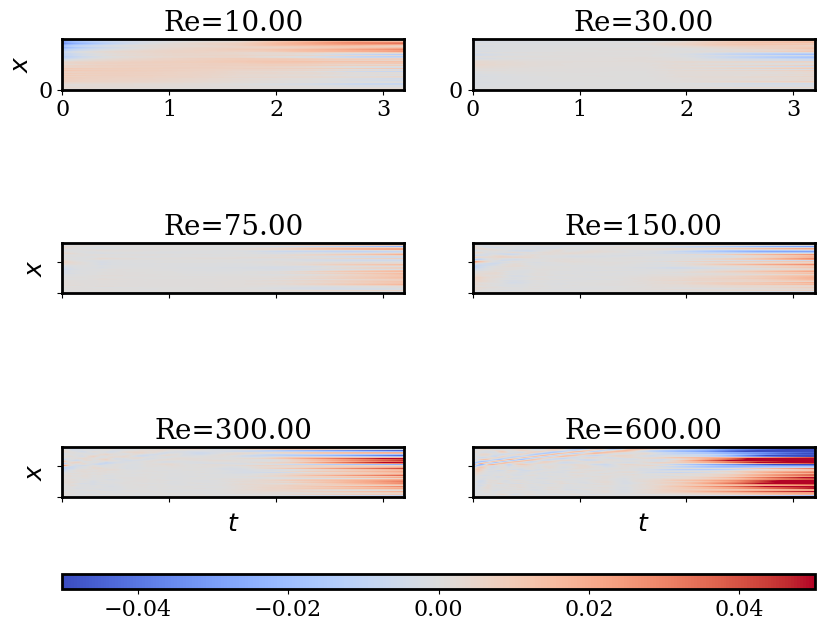

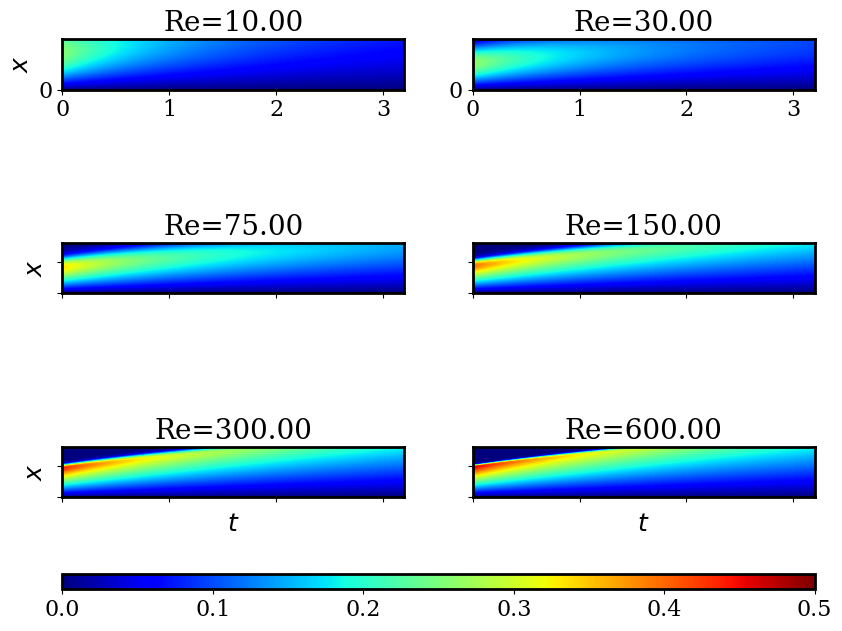

In [9]:
ae_model3,_ = loaded_ae_model3

## test AE predictions
pred_scaled = ae_model3.predict(test_data_scaled[:,:])
pred = scaler.scale_inverse((pred_scaled,))

true_field = np.reshape(np.array(test_data),(len(re_test_list),vtn,vxn))
true_field = np.moveaxis(true_field,1,2)

pred_field = np.reshape(np.array(pred),(len(re_test_list),vtn,vxn))
pred_field = np.moveaxis(pred_field,1,2)

valmax = np.amax([pred_field,true_field]) #true_field.max(); print(valmax)
valmin = np.amin([pred_field,true_field])  #true_field.min(); print(valmin)


lvls = np.linspace(np.amin([pred_field,true_field]),np.amax([pred_field,true_field]),50)
tks = lvls[0:-1:10]

fig, axs = plt.subplots(1,2, figsize=(15,5))
f1 = axs[0].imshow(true_field[-1],cmap='jet',origin='lower',vmin=valmin, vmax=valmax, extent=(0,T_test,0,L_test), aspect = 0.59)
plt.colorbar(f1, ticks = tks, orientation='horizontal',shrink=0.8,aspect=30, pad = 0.09)

f2 = axs[1].imshow(pred_field[-1],cmap='jet',origin='lower',vmin=valmin, vmax=valmax, extent=(0,T_test,0,L_test), aspect = 0.59)
plt.colorbar(f2, ticks = tks, orientation='horizontal',shrink=0.8,aspect=30, pad = 0.09)

axs[0].set_title(f"True solution")
axs[1].set_title(f"AE solution")

# fig.suptitle(f"{key} at t = {mesh['t'][int(itn%Nt)]/3600} hrs")

train_ls = ae_model3.encoder(train_data_scaled)
val_ls = ae_model3.encoder(val_data_scaled)
test_ls = ae_model3.encoder(test_data_scaled)

Nt_train = train_data_scaled.shape[0]
Nt_val = val_data_scaled.shape[0]
Nt_test = test_data_scaled.shape[0]

latent_dim = train_ls.shape[1]
# assert latent_dim == trial.params['latent_space'], "Optuna trials not available"

train_ls = np.reshape(train_ls,(len(re_train_list),vtn,latent_dim))
val_ls = np.reshape(val_ls,(len(re_val_list),int(Nt_val/len(re_val_list)),latent_dim))
test_ls = np.reshape(test_ls,(len(re_test_list),int(Nt_test/len(re_test_list)),latent_dim))

b_train, t_train, target_train = multiple_ldon_burgers(Re_train,vxn,VX_train,L_train,vtn,VT_train,T_train,train_ls)
b_val, t_val, target_val = multiple_ldon_burgers(Re_val,vxn,VX_val,L_val,vtn,VT_val,T_val,val_ls)


if scaling is True:
    t_scaler = MinMaxScaler(feature_range=( scaler_min,  scaler_max))
    b_scaler = MinMaxScaler(feature_range=( scaler_min,  scaler_max))
    ls_scaler = MinMaxScaler(feature_range=( scaler_min,  scaler_max))

    # changed global scaling, easier for now - PRC
    t_scaler.fit(np.concatenate([t_train,t_val]))
    b_scaler.fit(np.concatenate([b_train,b_val]))
    ls_scaler.fit(np.concatenate([target_train,target_val]))

    t_train = np.squeeze(t_scaler.transform(t_train))
    b_train = b_scaler.transform(b_train)
    target_train = np.squeeze(ls_scaler.transform(target_train))
    
    t_val = np.squeeze(t_scaler.transform(t_val))
    b_val = b_scaler.transform(b_val)
    target_val = np.squeeze(ls_scaler.transform(target_val))
    

## Evaluate the trained LDON model on test data
b_test, t_test, target_test = multiple_ldon_burgers(Re_test,vxn,VX_test,L_test,vtn,VT_test,T_test,test_ls)

if scaling is True:

    t_test = np.squeeze(t_scaler.transform(t_test))
    b_test = b_scaler.transform(b_test)
    target_test = np.squeeze(ls_scaler.transform(target_test))
    
    
model3 = loaded_don_model3

res = model3([b_test, t_test])

if  scaling is True:
    res = ls_scaler.inverse_transform(res)
    
full_res = ae_model3.decoder(res).numpy()
full_res = np.squeeze(scaler.scale_inverse((full_res,)))


test = np.reshape(np.array(full_res),(len(re_test_list),vtn,vxn))
target = np.reshape(np.array(test_data_unscaled),(len(re_test_list),vtn,vxn))

    
# full_res = ae_model3.decoder(res).numpy()
# full_res = np.squeeze(scaler.scale_inverse((full_res,)))


# test = np.reshape(np.array(full_res),(len(re_test_list),vtn,vxn))
# target_test = np.reshape(np.array(test_data_unscaled),(len(re_test_list),vtn,vxn))


error = test - target
rmse333 = np.sqrt(np.mean((test - target)**2))


plot_bounds_1d(target[0].T,test[0].T,error[0].T, L_test, T_test, label1= re_test_list[0], vmin1=0, vmax1=0.5,name='low_re'+str(i))
plot_bounds_1d(target[-1].T,test[-1].T,error[-1].T, L_test, T_test, label1= re_test_list[-1], vmin1=0, vmax1=0.5, name='high_re'+str(i))

# test[:,:,id_t]=1000
# test[:,id_x,:]=1000
# burgers_array_test[:,:,id_t]=1000
# burgers_array_test[:,id_x,:]=1000
# error[:,:,id_t]=1000
# error[:,id_x,:]=1000

plot_spcaetime_1d(test[0].T,test[1].T,
                  test[2].T,test[3].T,
                  test[4].T,test[5].T,
                  T_test,L_test,label1= re_test_list,
                  vmin1=0,
                  vmax1=0.5,                      
                  name='prediction'+str(i))

plot_spcaetime_1d(error[0].T,error[1].T,
                  error[2].T,error[3].T,
                  error[4].T,error[5].T,
                  T_test,L_test,
                  colormap='coolwarm',label1= re_test_list,
                  vmin1=-0.05,
                  vmax1=0.05,
                  name='error'+str(i))

plot_spcaetime_1d(target[0].T,target[1].T,
                  target[2].T,target[3].T,
                  target[4].T,target[5].T,
                  T_test,L_test,label1= re_test_list,
                  vmin1=0,
                  vmax1=0.5,    
                  name='truth')